## 4. Data Labelling - Supervised 
#### Written by: Isobel Jones
#### Date: 22nd of June

1. Load and deserialise pickled data 
2. Make the 5 categories contain equal number of instances (reduce class imbalance). This is now not used.
3. Split data into 80/20 train/test datasets
4. Train Models
  - Start of with simple ML algorithm
  - Perform optimization with gridsearch to find optimum hyperparameters
  - Re-run model using hyperparameters
5. Deep Dive On Tweets

In [1]:
import os
import nltk
import pickle
import numpy as np
from nltk.classify import NaiveBayesClassifier
from nltk.classify.util import accuracy
from sklearn import cross_validation
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

/Users/isobeljones/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Get Root working directory

In [2]:
rootwd = os.path.abspath(os.path.join(os.path.dirname(os.getcwd())))
print('Root Working Directory:\n\n', rootwd)

Root Working Directory:

 /Users/isobeljones/DataScience/topic-labelling-system


#### 1. Load and deserialise pickled data

In [3]:
def loadData(path):
    #Open the file for reading
    fileObject = open(path,'rb')

    # load the object from the file into var b
    loadedTweets = pickle.load(fileObject)
    return loadedTweets

Create functions to separate data into features and labels

In [4]:
def tweetscategorys(data, category='all'):
    if category == 'all':
        x = [x[:][1:] for x in data]
    elif category == 'alllenghtsame':
        categories = ['Complaint','Other','Find My Item','Engagement','Enquiry']
        x=[]
        for c in categories:
            a = [x[:][1:] for x in data if x[2] == c]#[:391]
            x.extend(a)
    else:
        #This returns one category worth of data (features & labels)
        x = [x[:][1:] for x in data if x[2] == category]
    return x
#Split the data into features and labels
def tweetstofeatures(data):
    if len(data) > 2000:
        x = [x[:][1] for x in data]
    else:
        x = [x[:][:][0] for x in data ]
    return x

def tweetstolabels(data):
    if len(data) > 2000:
        y = [x[:][2] for x in data ]
    else:
        y = [x[:][:][1] for x in data ]
    return y

In [5]:
file_name = rootwd + '/data/GDPRcompliantTweets.dump'

cleanedtweets = loadData(file_name)

#### 2. Make the 5 categories contain equal number of instances (reduce class imbalance). This is now not used.

In [6]:
z = tweetscategorys(cleanedtweets) # features & labels
x = tweetstofeatures(cleanedtweets) # features
y = tweetstolabels(cleanedtweets) # labels

#Number of instanes is the same
g = tweetscategorys(cleanedtweets,'alllenghtsame')
xg = [x[:][:][0] for x in g ]
yg = [x[:][:][1] for x in g ]

In [7]:
#xg= [[' '.join(x)] for x in xg]

In [8]:
#ros = RandomOverSampler(random_state=777)
#xg, yg = ros.fit_sample(xg, yg)

#### 3. Split the data into Train Test datasets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(xg, yg, test_size=0.2)

Oversample the data 
Commented out as not oversampling or undersampling the data anymore

In [10]:
'''
X_train = [[' '.join(x)] for x in X_train] # Remove tokenisation
X_test = [[' '.join(x)] for x in X_test] # Remove tokenisation
ros = RandomOverSampler()
X_train, y_train = ros.fit_sample(X_train, y_train)
from collections import Counter
print(sorted(Counter(y_train).items()))
'''

"\nX_train = [[' '.join(x)] for x in X_train] # Remove tokenisation\nX_test = [[' '.join(x)] for x in X_test] # Remove tokenisation\nros = RandomOverSampler()\nX_train, y_train = ros.fit_sample(X_train, y_train)\nfrom collections import Counter\nprint(sorted(Counter(y_train).items()))\n"

Remove tokenisation

In [11]:
X_train = [' '.join(x) for x in X_train] # Remove tokenisation
X_test = [' '.join(x) for x in X_test] # Remove tokenisation

Create function to return detailed metrics of interest which takes a pipeline as input

In [12]:
classlabels = ['Complaint','Other','Find My Item','Engagement','Enquiry']

def print_classification_matrix(y_test, predicted):
    array = confusion_matrix(y_test, predicted, labels=classlabels)
    df_cm = pd.DataFrame(array, classlabels, classlabels)
    plt.figure(figsize = (10,7))
    sn.set(font_scale=1.4)#for label size
    ax = plt.axes()
    ax.set_title('Confusion Matrix')
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 12},cmap='Blues', fmt='g')# font size
    
def get_results(text_clf):
    text_clf = text_clf.fit(X_train, y_train)
    predicted = text_clf.predict(X_test)
    # Cross Validation with 3 folds
    scores = cross_validation.cross_val_score(text_clf, X_train, y_train, cv=3)
    
    print('Each value is the accuracy score of the support vector classifier when leaving out a different fold.\n', scores)
    print('\nOverall Model Accuracy:', scores.mean())
    print('Labels: ', classlabels)
    print('Recall:', recall_score(y_test, text_clf.predict(X_test), average=None))
    print('Precison:', precision_score(y_test, text_clf.predict(X_test), average=None))

    print_classification_matrix(y_test, predicted)

## 4. Train Models

1. Start of with simple ML algorithm
2. Perform optimization with gridsearch to find optimum hyperparameters
3. Re-run model using hyperparameters

Classifiers used:
 - Multinomial Naive Bayes
 - Stochastic Gradient Descent
 - One Verse Rest
 - Linear SVC

### Multinomial Naive Bayes
##### 1. Fit model without any hyperparameters

Each value is the accuracy score of the support vector classifier when leaving out a different fold.
 [0.57973806 0.57371362 0.57016191]

Overall Model Accuracy: 0.5745378652107952
Labels:  ['Complaint', 'Other', 'Find My Item', 'Engagement', 'Enquiry']
Recall: [0.94561404 0.29391304 0.01841621 0.46428571 0.        ]
Precison: [0.5313835  0.92349727 0.66666667 0.69785276 0.        ]


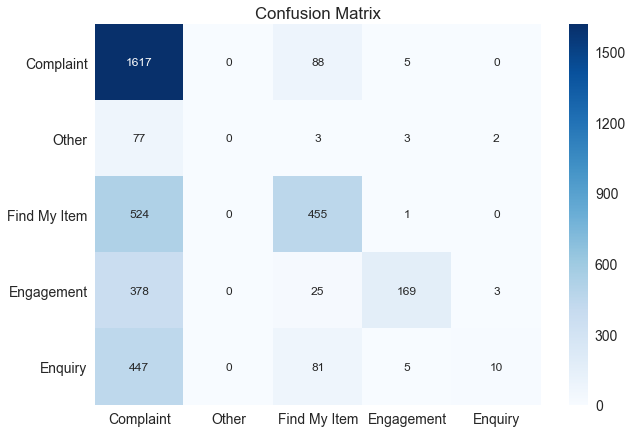

In [13]:
text_clf_mb = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB()),
])
get_results(text_clf_mb)

 ##### 2. Learn optimal paramters using gridsearch

In [14]:
parameters = {
    'clf__alpha': [0.001, 0.0001, 0.00001, 0.000001],
    'clf__fit_prior':['True', 'False'],
    'vect__ngram_range':[(1, 2),(1, 3),(1, 5),(1, 7),(1, 9)],
    'tfidf__use_idf':['True', 'False'],
    'tfidf__sublinear_tf':['True', 'False'],
    'tfidf__norm':['l2', 'l1']
}

grid_search = GridSearchCV(text_clf_mb, parameters, n_jobs=3,verbose=1)

grid_search.fit(X_train, y_train)
grid_search.best_score_
grid_search.best_params_

Fitting 3 folds for each of 320 candidates, totalling 960 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   21.6s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  3.6min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  6.3min
[Parallel(n_jobs=3)]: Done 960 out of 960 | elapsed:  7.6min finished


{'clf__alpha': 0.001,
 'clf__fit_prior': 'True',
 'tfidf__norm': 'l1',
 'tfidf__sublinear_tf': 'True',
 'tfidf__use_idf': 'True',
 'vect__ngram_range': (1, 2)}

##### 3. Fit model using hyperparameters learnt above

Multinomial Classifier
Each value is the accuracy score of the support vector classifier when leaving out a different fold.
 [0.61979969 0.60994411 0.61603701]

Overall Model Accuracy: 0.6152602709534901
Labels:  ['Complaint', 'Other', 'Find My Item', 'Engagement', 'Enquiry']
Recall: [0.89298246 0.50608696 0.15285451 0.53877551 0.10588235]
Precison: [0.58685626 0.85840708 0.56081081 0.66415094 1.        ]


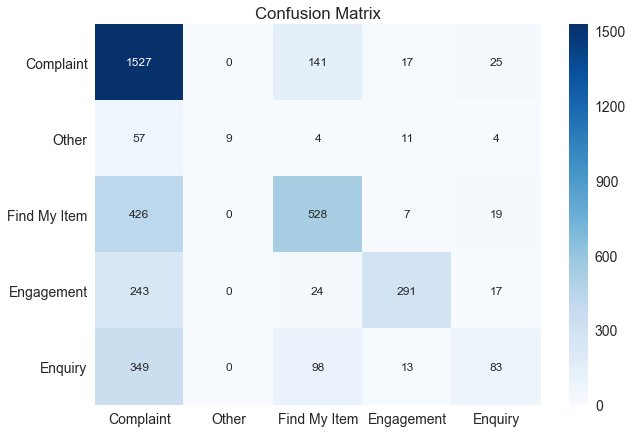

In [15]:
text_clf_mb = Pipeline([('vect', CountVectorizer(ngram_range=(1, 3),lowercase=False)),
                    ('tfidf', TfidfTransformer(norm='l1', sublinear_tf=True)),
                    ('clf', MultinomialNB(alpha=1e-3, fit_prior=True)),
])
print('Multinomial Classifier')
get_results(text_clf_mb)

### Stochastic Gradiant Descent
##### 1. Fit model without any hyperparameters

SGDClassifier 

Each value is the accuracy score of the support vector classifier when leaving out a different fold.
 [0.63886749 0.63210638 0.64051658]

Overall Model Accuracy: 0.6371634813458845
Labels:  ['Complaint', 'Other', 'Find My Item', 'Engagement', 'Enquiry']
Recall: [0.85964912 0.53391304 0.14548803 0.63265306 0.09411765]
Precison: [0.62025316 0.83197832 0.49685535 0.63136456 0.61538462]


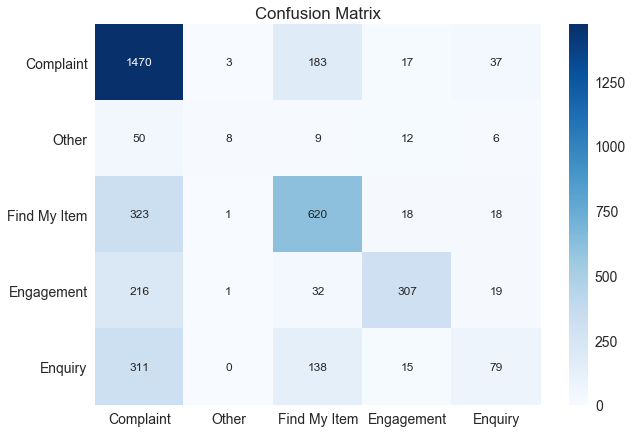

In [16]:
text_clf_sgd = Pipeline([
                        ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                      ('clf', SGDClassifier(alpha=1e-4, max_iter=1000 )),
])


text_clf_sgd = text_clf_sgd.fit(X_train, y_train)
predicted_sgd = text_clf_sgd.predict(X_test)

print('SGDClassifier \n')
get_results(text_clf_sgd)

 ##### 2. Learn optimal paramters using gridsearch

In [17]:
parameters = {
    'clf__max_iter':[10, 100, 1000],
    'clf__alpha': [0.001, 0.0001, 0.00001, 0.000001],
    'tfidf__ngram_range' : [(1, 2),(1, 3),(1, 5),(1, 7),(1, 9)]
}

#score_func = make_scorer(metrics.f1_score)
#, scoring=score_func
grid_search = GridSearchCV(text_clf_sgd, parameters, n_jobs=3,verbose=1)

grid_search.fit(X_train, y_train)
grid_search.best_score_
grid_search.best_params_

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.6min
[Parallel(n_jobs=3)]: Done 180 out of 180 | elapsed:  6.2min finished


{'clf__alpha': 0.0001, 'clf__max_iter': 1000, 'tfidf__ngram_range': (1, 2)}

##### 3. Fit model using hyperparameters learnt above

SGDClassifier 

Each value is the accuracy score of the support vector classifier when leaving out a different fold.
 [0.6392527  0.63210638 0.64051658]

Overall Model Accuracy: 0.6372918840166601
Labels:  ['Complaint', 'Other', 'Find My Item', 'Engagement', 'Enquiry']
Recall: [0.86023392 0.53391304 0.14548803 0.63265306 0.09411765]
Precison: [0.62041333 0.83197832 0.49685535 0.63200815 0.61538462]


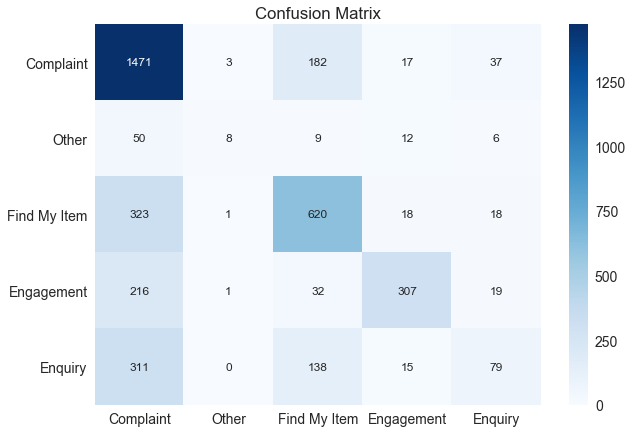

In [18]:
text_clf_sgd = Pipeline([
                        ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                      ('clf', SGDClassifier(alpha=1e-4, max_iter=1000 ,)),
])


text_clf_sgd = text_clf_sgd.fit(X_train, y_train)
predicted_sgd = text_clf_sgd.predict(X_test)

print('SGDClassifier \n')
get_results(text_clf_sgd)

### One Verse Rest
##### 1. Fit model without any hyperparameters

one v rest 

Each value is the accuracy score of the support vector classifier when leaving out a different fold.
 [0.57338213 0.5696666  0.56958365]

Overall Model Accuracy: 0.5708774611213171
Labels:  ['Complaint', 'Other', 'Find My Item', 'Engagement', 'Enquiry']
Recall: [0.95555556 0.26434783 0.01289134 0.43265306 0.        ]
Precison: [0.52087982 0.93251534 0.77777778 0.7260274  0.        ]


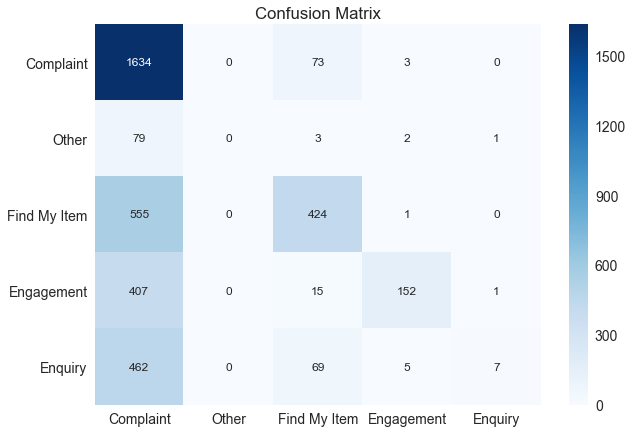

In [19]:
onevrestclassifier = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(MultinomialNB()),)])

print('one v rest \n')
get_results(onevrestclassifier)

 ##### 2. Learn optimal paramters using gridsearch

In [20]:
parameters = {
    'tfidf__use_idf':['True', 'False'],
    'tfidf__sublinear_tf':['True', 'False'],
    'tfidf__norm':['l2', 'l1'],
    'vectorizer__ngram_range' : [(1, 2),(1, 3),(1, 5),(1, 7),(1, 9)]
}

#score_func = make_scorer(metrics.f1_score)
#, scoring=score_func
grid_search = GridSearchCV(onevrestclassifier, parameters, n_jobs=3,verbose=1)

grid_search.fit(X_train, y_train)
grid_search.best_score_
grid_search.best_params_

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   22.9s
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:  1.0min finished


{'tfidf__norm': 'l2',
 'tfidf__sublinear_tf': 'True',
 'tfidf__use_idf': 'True',
 'vectorizer__ngram_range': (1, 2)}

##### 3. Fit model using hyperparameters learnt above

one v rest 

Each value is the accuracy score of the support vector classifier when leaving out a different fold.
 [0.57338213 0.56908846 0.5693909 ]

Overall Model Accuracy: 0.5706204949266421
Labels:  ['Complaint', 'Other', 'Find My Item', 'Engagement', 'Enquiry']
Recall: [0.95614035 0.26608696 0.01289134 0.43265306 0.        ]
Precison: [0.5211986  0.93292683 0.77777778 0.72727273 0.        ]


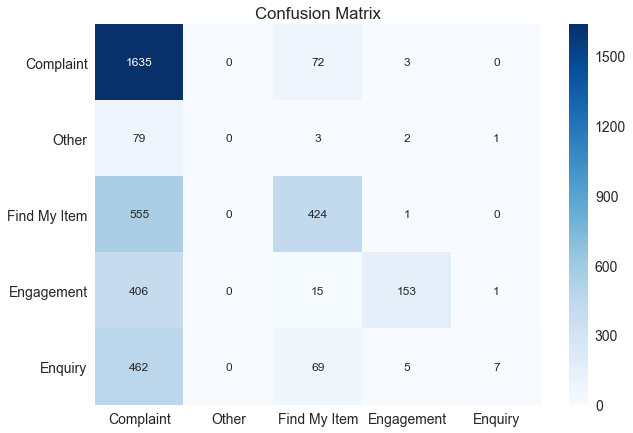

In [21]:
onevrestclassifier = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer(norm='l2',sublinear_tf='True')),
    ('clf', OneVsRestClassifier(MultinomialNB()),)])

print('one v rest \n')
get_results(onevrestclassifier)

### Linear Support Vector Classifier
##### 1. Fit model without any hyperparameters

LinearSVC 

Each value is the accuracy score of the support vector classifier when leaving out a different fold.
 [0.63385978 0.62960108 0.63145721]

Overall Model Accuracy: 0.6316393574777474
Labels:  ['Complaint', 'Other', 'Find My Item', 'Engagement', 'Enquiry']
Recall: [0.8251462  0.56521739 0.26703499 0.62959184 0.11764706]
Precison: [0.64223942 0.8186398  0.46325879 0.63805584 0.52631579]


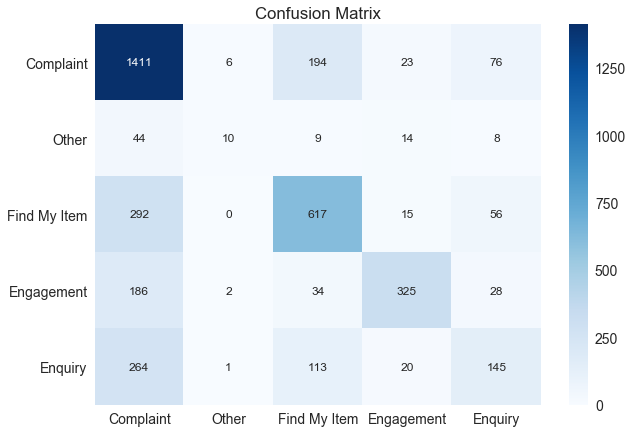

In [22]:
linearsvc_classifier = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC())])

print('LinearSVC \n')
get_results(linearsvc_classifier)

 ##### 2. Learn optimal paramters using gridsearch

In [23]:
parameters = {
    'tfidf__use_idf':['True', 'False'],
    'tfidf__sublinear_tf':['True', 'False'],
    'tfidf__norm':['l2', 'l1'],
    'vectorizer__ngram_range' : [(1, 2),(1, 3),(1, 5),(1, 7),(1, 9)]
}

#score_func = make_scorer(metrics.f1_score)
#, scoring=score_func
grid_search = GridSearchCV(linearsvc_classifier, parameters, n_jobs=3,verbose=1)

grid_search.fit(X_train, y_train)
grid_search.best_score_
grid_search.best_params_

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   33.9s
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:  1.5min finished


{'tfidf__norm': 'l2',
 'tfidf__sublinear_tf': 'True',
 'tfidf__use_idf': 'True',
 'vectorizer__ngram_range': (1, 2)}

 ###### 3. Fit model using hyperparameters learnt above# 2. Learn optimal paramters using gridsearch

LinearSVC 

Each value is the accuracy score of the support vector classifier when leaving out a different fold.
 [0.63385978 0.62960108 0.63145721]

Overall Model Accuracy: 0.6316393574777474
Labels:  ['Complaint', 'Other', 'Find My Item', 'Engagement', 'Enquiry']
Recall: [0.8251462  0.56521739 0.26703499 0.62959184 0.11764706]
Precison: [0.64223942 0.8186398  0.46325879 0.63805584 0.52631579]


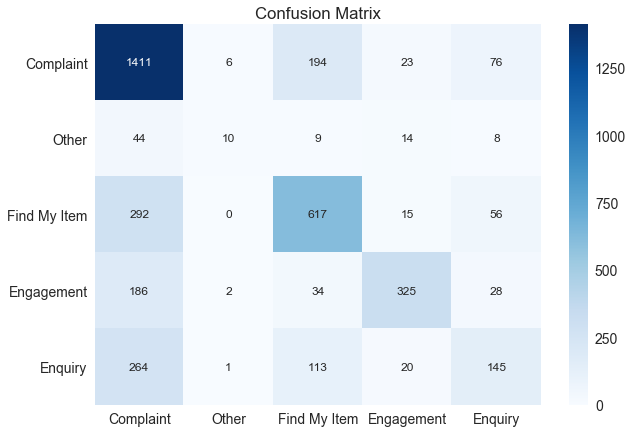

In [24]:
linearsvc_classifier = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC())])

print('LinearSVC \n')
get_results(linearsvc_classifier)

### Deep Dive on Tweets

In [25]:
linearsvc_classifier = linearsvc_classifier.fit(X_train, y_train)
predicted = linearsvc_classifier.predict(X_test)

missclassifiedindex= []

predictedindex = []
[predictedindex.append(i) for i,x, in enumerate(predicted.tolist())]

for i in predictedindex:
    if y_test[i] != predicted[i]:
        missclassifiedindex.append(i)
    
    #a = [missclassifiedindex.append(i) for i,x in enumerate(missclassified.tolist()) if x == True]

In [26]:
print('Misclassified tweets')
for x in missclassifiedindex:
    print( X_test[x])
    print('actual:',y_test[x])
    print('predicted: ',predicted_sgd[x])
    print('--------------')

Misclassified tweets
bit frustrating responded query morning mine
actual: Find My Item
predicted:  Complaint
--------------
staff maybe stockton sorting office
actual: Other
predicted:  Complaint
--------------
thank cute apology bag nothing missingdamaged good book
actual: Engagement
predicted:  Complaint
--------------
great stuff amazonuk parcel turn wait thing done crazy poor
actual: Find My Item
predicted:  Complaint
--------------
parcel wrong address sender addy markd return sender put post box happens
actual: Enquiry
predicted:  Find My Item
--------------
posted yesterday special delivery guaranteed arrived progressing compensation
actual: Complaint
predicted:  Find My Item
--------------
millieclinton mind paying quid handling fee annoys hahaha
actual: Enquiry
predicted:  Complaint
--------------
tell mail delivered area postcode ha sr waiting parcel
actual: Find My Item
predicted:  Find My Item
--------------
dominosuk delivered
actual: Enquiry
predicted:  Find My Item
-----

predicted:  Complaint
--------------
jomillerdonny mydoncaster mydoncaster jomillerdonny shame victim latest able vote eh chokingonyourfum
actual: Complaint
predicted:  Engagement
--------------
call dhlitnowuk thought might send stamp using system told customer like stamp
actual: Engagement
predicted:  Complaint
--------------
amazonhelp hermesdelivery tried online chat hermes referred someone deliver parcel anyone dpduk
actual: Enquiry
predicted:  Complaint
--------------
reply
actual: Complaint
predicted:  Find My Item
--------------
chrishammondha chris closing time delivery window tracking_number often arrive time lp
actual: Complaint
predicted:  Find My Item
--------------
useless where wild goose chase pick disapeard chainreact
actual: Find My Item
predicted:  Complaint
--------------

actual: Enquiry
predicted:  Complaint
--------------
credit where due thank staff springburn helped damsel distess good deed complete
actual: Complaint
predicted:  Other
--------------
told transi

actual: Enquiry
predicted:  Complaint
--------------
apparently plan building stagecoach handy renovating capel curig
actual: Engagement
predicted:  Complaint
--------------
someone claim work wrote
actual: Enquiry
predicted:  Complaint
--------------
parcel monday delivered sat sorting office perishable good spolied compensate wo
actual: Find My Item
predicted:  Complaint
--------------
take action postman spraying water assault every right stop
actual: Enquiry
predicted:  Complaint
--------------
card collect delivered yesterday required signature post office told
actual: Find My Item
predicted:  Complaint
--------------
penning sawilton aspjoeiles aspolice done legally seems like pretty legit reason someth
actual: Other
predicted:  Complaint
--------------
asked gary grange payroll giving important thing employer offer staff
actual: Other
predicted:  Complaint
--------------
laurenojohn try mail package leaf state really hand sorry lb
actual: Engagement
predicted:  Complaint
-------

predicted:  Complaint
--------------
usps delivered parcel box error loststolen claim compensation
actual: Find My Item
predicted:  Complaint
--------------
kind great service provides
actual: Enquiry
predicted:  Complaint
--------------
take elastic band
actual: Enquiry
predicted:  Complaint
--------------
struggling contact parcel believe ha gone miss
actual: Find My Item
predicted:  Find My Item
--------------
haven reply previous tweet
actual: Enquiry
predicted:  Find My Item
--------------
doubt load reply leave where parcel delivering
actual: Find My Item
predicted:  Complaint
--------------
delighted see princess commemorative sheet available
actual: Engagement
predicted:  Find My Item
--------------
scoobydoofus yeah mean menu landscaping leaflet post annoying opt
actual: Complaint
predicted:  Enquiry
--------------
post office barely took minute sort driving licence renewal excellent work
actual: Other
predicted:  Complaint
--------------
told collect parcel driver ha taken va

actual: Enquiry
predicted:  Find My Item
--------------
big lady post office super cheery friendly though ikea bag full track sign parcel 👏
actual: Other
predicted:  Find My Item
--------------
gonna post parcel someone else hous
actual: Enquiry
predicted:  Complaint
--------------
falcondalejan collected death son impact rest kid health missing delivery ha impact
actual: Complaint
predicted:  Complaint
--------------
unable mill hill poffice week close info required mail wks
actual: Enquiry
predicted:  Complaint
--------------
dad deserves emoji father latest work
actual: Engagement
predicted:  Complaint
--------------
northernbirdy sadly anyone bristol trust vote pretty important
actual: Complaint
predicted:  Engagement
--------------
wait till monday highly annoy
actual: Enquiry
predicted:  Complaint
--------------
received something card address appears mine name card wrong name flat number
actual: Enquiry
predicted:  Complaint
--------------
booked parcel redelivery email confirma

--------------
fucking respect queuing outside collect parcel dick
actual: Engagement
predicted:  Complaint
--------------
liamtheblade thanks liam kind comment always 👍 🏽
actual: Engagement
predicted:  Complaint
--------------
aware resident middorset northpoole received electionaddress last scheduled b manchester attack
actual: Engagement
predicted:  Complaint
--------------
p door left neighbour didn knocked neighbour parcel
actual: Find My Item
predicted:  Complaint
--------------
number gone missing raise thank
actual: Complaint
predicted:  Find My Item
--------------
contact regarding hasn delivered caitlin barraclough replied irrelevant tamp c 😠 mufc dhl
actual: Complaint
predicted:  Find My Item
--------------
misslaura edsheeran seems like reasonable response
actual: Find My Item
predicted:  Complaint
--------------
delivery delivered neighbour morning card neighbour
actual: Find My Item
predicted:  Complaint
--------------
tracking tracking_number transfer post office try red

predicted:  Find My Item
--------------
dpduk thank ignoring dpd slower normal mail better use
actual: Engagement
predicted:  Complaint
--------------
urgent run label reason rm wrong dmo printing
actual: Enquiry
predicted:  Complaint
--------------
reason missed street waiting recorded mail arrived yesterday
actual: Find My Item
predicted:  Complaint
--------------
echohealthcare hmm always thought standard size mailbox true fit neighbour usually take anything though
actual: Complaint
predicted:  Complaint
--------------
jiggy use stick saturday hasn arrived 🏏
actual: Engagement
predicted:  Find My Item
--------------
lovely lady tell payment system delievery system talk reschedule delivery
actual: Find My Item
predicted:  Complaint
--------------
misscandysarah ahh able luk
actual: Enquiry
predicted:  Engagement
--------------
catherinesneyd hard working company charge someone twice mistake wrong
actual: Engagement
predicted:  Complaint
--------------
paid £ work address delivered op

skipratmedia called thousand time missing parcel deliver post office without ringing bell leaving
actual: Enquiry
predicted:  Complaint
--------------
word advice apologise causing convenience good thing
actual: Enquiry
predicted:  Complaint
--------------
jackricketts absolutely fantastic bleeding expensive parcel thursday ha movement aepting bank holiday excus
actual: Find My Item
predicted:  Complaint
--------------
believe paid £ send mum birthday card first class monday hasn 🙃 🙃
actual: Find My Item
predicted:  Complaint
--------------
postoffice lewisham shopping centre post office inside whsmith fact cut staff appalling
actual: Engagement
predicted:  Complaint
--------------
huge sholut john slough collection dep super busy find time delight customer asset thanks
actual: Other
predicted:  Complaint
--------------
where post man
actual: Enquiry
predicted:  Complaint
--------------
kirkcaldy depot open find info anywhere
actual: Engagement
predicted:  Complaint
--------------
issu

predicted:  Enquiry
--------------
reference number tracking_numb
actual: Find My Item
predicted:  Find My Item
--------------
ha postman gone missing
actual: Enquiry
predicted:  Complaint
--------------
special delivery guarantee deliver ireland
actual: Enquiry
predicted:  Find My Item
--------------
adambarnes yep great time board start journey grandplan
actual: Engagement
predicted:  Complaint
--------------
home rang doorbell parcel delivered neighbour delivered
actual: Find My Item
predicted:  Complaint
--------------
bryonystamper jlkondabeka hahahaha deal 😂 😩 good luck bb
actual: Engagement
predicted:  Engagement
--------------
hiya posted sd sunday showing everything
actual: Find My Item
predicted:  Find My Item
--------------
thanks waited delivery texted nearly ten clock dark nowt zip zilch noth
actual: Find My Item
predicted:  Complaint
--------------
work pal
actual: Other
predicted:  Complaint
--------------
bit worried someone ha signed name parcel receive home till tomor

### Show Most Imformative Features

In [27]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print( "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [28]:
# vectorizer = text_clf.named_steps['vect']
# clf = text_clf.named_steps['clf']

# #The above print shows the top 20 lowest values (less predictive features) in the first column 
# #and the top 20 high values (highest predictive features) in the second column.
# show_most_informative_features(vectorizer,clf,n=200)

In [29]:
import seaborn as sns; sns.set()
mat = confusion_matrix(y_test, predicted_svm)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=y_train, yticklabels=y_train)
plt.xlabel('true label')
plt.ylabel('predicted label');

NameError: name 'predicted_svm' is not defined